In [1]:
import shapely as shapely
from shapely.ops import split,substring
from shapely.geometry import Point,mapping, LineString, Polygon, MultiPoint
import numpy as np
import rasterio
from rasterio import plot, mask
from rasterio.crs import CRS
from rtree import index
import networkx as nx
import geopandas as gpd
import os
import matplotlib.pyplot as plt
from cartopy import crs
from math import atan, degrees
import rioxarray

C:\Users\raffy\anaconda3\envs\ATN_Devon\lib\site-packages\geopandas\_compat.py:110: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


In [2]:
OS_National_Grids = gpd.read_file(os.path.join('OS-British-National-Grids-main','OS-British-National-Grids-main','os_bng_grids.gpkg'),layer='1km_grid')

In [3]:
study_area_shapely = OS_National_Grids[OS_National_Grids['tile_name'] == "SX7677"].geometry.cascaded_union

In [4]:
Haytor_map = rasterio.open(
        os.path.join('OS Explorer Maps', 'Download_SX77-Haytor_2033809', 'raster-25k_4596071', 'sx', 'sx77.tif'))
elevation = rasterio.open(os.path.join('OS Elevation','Download_Haytor_Elevation_2035988','terrain-5-dtm_4600215','sx','SX77NE.asc'))

study_area = mapping(study_area_shapely)
elevation_mask, transform_index = mask.mask(elevation,[study_area], filled=False, crop=False)

network_links = gpd.read_file(os.path.join('Study_area','SX7677','network_links.geojson'))
network_nodes = gpd.read_file(os.path.join('Study_area','SX7677','network_nodes.geojson'))

##  3. DNPA Land Cover Maps 2021

In [38]:
land_use = rasterio.open(os.path.join('Environmental Land Use Data','Dartmoor_land_use_converted.tif'))

In [27]:
land_use_mask, land_use_transform_index = mask.mask(land_use,[study_area], filled=False, crop=False)

C:\Users\raffy\anaconda3\envs\ATN_Devon\lib\site-packages\ipykernel_launcher.py:8: UserWarning: The default value for the *approx* keyword argument to OSGB will change from True to False after 0.18.
  
C:\Users\raffy\anaconda3\envs\ATN_Devon\lib\site-packages\ipykernel_launcher.py:23: UserWarning: The default value for the *approx* keyword argument to OSGB will change from True to False after 0.18.


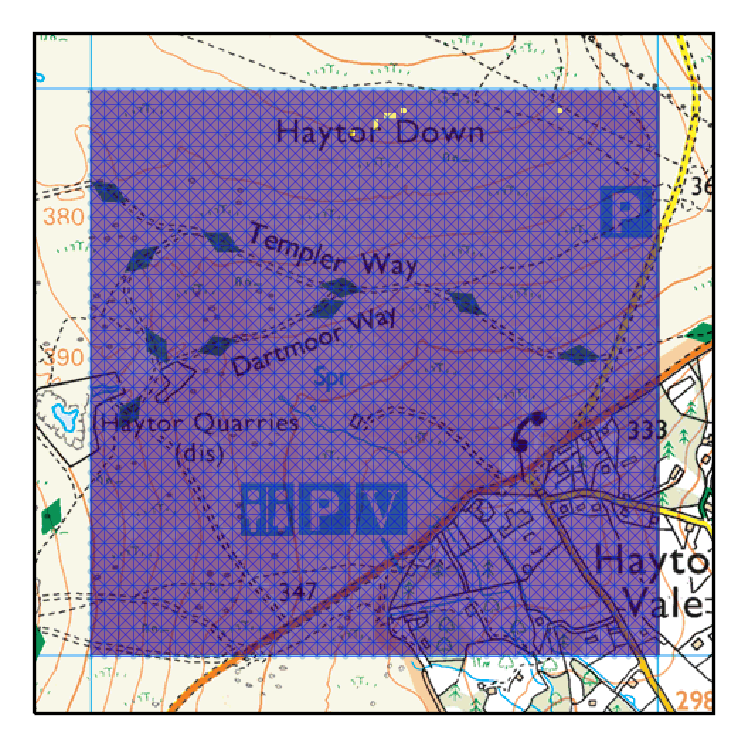

In [31]:
back_array = Haytor_map.read(1)
palette = np.array([value for key, value in Haytor_map.colormap(1).items()])
background_image = palette[back_array]
bounds = Haytor_map.bounds
extent = (bounds.left, bounds.right, bounds.bottom, bounds.top)

fig = plt.figure(figsize=(3, 3), dpi=300)
ax = fig.add_subplot(1, 1, 1, projection=crs.OSGB())

ax.imshow(background_image, origin='upper', extent=extent, zorder=0)

# display land_use
rasterio.plot.show(land_use_mask, alpha=0.6, transform=land_use_transform_index, ax=ax, zorder=1)
# displaying nodes
network_nodes.plot(ax=ax, zorder=3, markersize=0.2, alpha=0.3)

# displaying links
network_links.plot(ax=ax, zorder=2, edgecolor='blue', linewidth=0.2, alpha=0.3)

display_extent = ((study_area_shapely.bounds[0]- 100, study_area_shapely.bounds[2]+ 100,
                       study_area_shapely.bounds[1]- 100, study_area_shapely.bounds[3]+ 100))

ax.set_extent(display_extent, crs=crs.OSGB())
plt.show()

In [35]:
land_use = []
for index,row in network_nodes.iterrows():
    location = (row.geometry.x,row.geometry.y)
    point_index = rasterio.transform.rowcol(land_use_transform_index, location[0],
                                                    location[1])
    point_land_use = land_use_mask[0][point_index]
    land_use.append(point_land_use)

In [42]:
land_use_value = []
for index,row in network_nodes.iterrows():
    location = (row.geometry.x,row.geometry.y)
    row, col = land_use.index(location[0],location[1])
    # print("Point Corresponds to row, col: %d, %d"%(row,col))
    # print("Raster value on point %.2f \n"%land_use.read(1)[row,col])
    land_use_value.append(land_use.read(1)[row,col])
network_nodes['land_use'] = land_use_value

In [ ]:
points = []
height = []
for i in count_x:
    for j in count_y:
        points.append(Point(i,j))
        point_index = rasterio.transform.rowcol(transform_index, i,
                                                    j)
        point_elevation = elevation_mask[0][point_index]
        height.append(point_elevation)
nodes_gpd = gpd.GeoSeries(points)